# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups              
Sample_125  A0A024QZX5;A0A087X1N8;P35237   14.843
Sample_138  Q9H7Y0                         14.603
Sample_202  Q14697;Q14697-2                17.530
Sample_055  P60174;P60174-1                18.342
Sample_078  Q6UX72                         15.367
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                 
Sample_108  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   14.183
Sample_064  P40121;P40121-2                   14.872
Sample_015  A8MXB9;J3KQJ1;Q8NBJ7              14.193
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.219
            A0A075B6Q5                 13.344
            A0A075B6R2                 13.175
            A0A075B6S5                 12.117
            A0A087WSY4                 12.768
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.127
            Q9UI40;Q9UI40-2            12.035
            Q9UIW2                     12.622
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.220
            Q9UP79                     14.022
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.278,15.050,16.842,19.863,16.072,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.823,19.067,...,15.528,15.576,14.259,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.075,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.027,17.705,17.039,16.165,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.265,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.960,15.345,17.084,18.708,14.249,19.433,11.992,10.879
Sample_207,15.739,16.877,15.469,16.898,13.916,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.219,...,16.012,15.178,13.901,15.050,16.842,19.863,12.363,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.073,19.067,16.188,...,15.528,15.576,11.911,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,11.979,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.494,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.521,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.394,15.345,17.084,18.708,14.249,19.433,11.864,13.230
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 362.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.85it/s]

100%|██████████| 3/3 [00:00<00:00,  2.87it/s]

100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.34it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.66it/s]

100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.15it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.72it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.12it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.77it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.29it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.14it/s]

100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.99it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.60it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.18it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.14it/s]

100%|██████████| 7/7 [00:02<00:00,  2.16it/s]

100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.88it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.78it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.40it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.90it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.02it/s]

100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

100%|██████████| 8/8 [00:03<00:00,  2.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.90it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.78it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.41it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.21it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.20it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.06it/s]

100%|██████████| 9/9 [00:03<00:00,  2.05it/s]

100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.22it/s]

 30%|███       | 3/10 [00:00<00:02,  2.87it/s]

 40%|████      | 4/10 [00:01<00:02,  2.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.65it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.22it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.21it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.08it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.08it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.06it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.39it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.12it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.13it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.13it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.61it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

100%|██████████| 11/11 [00:06<00:00,  1.54it/s]

100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.82it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.99it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.83it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.80it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.82it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.68it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.49it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.24it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.07it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.93it/s]

100%|██████████| 12/12 [00:05<00:00,  2.05it/s]

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.60it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.87it/s]

 31%|███       | 4/13 [00:01<00:03,  2.76it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.40it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.35it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.22it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.28it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.18it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.95it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.79it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.80it/s]

100%|██████████| 13/13 [00:05<00:00,  1.90it/s]

100%|██████████| 13/13 [00:05<00:00,  2.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.63it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.03it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.81it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.70it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.72it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.61it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.25it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.18it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.01it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.11it/s]

100%|██████████| 14/14 [00:05<00:00,  2.17it/s]

100%|██████████| 14/14 [00:05<00:00,  2.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.86it/s]

 20%|██        | 3/15 [00:00<00:03,  3.68it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.27it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.04it/s]

 40%|████      | 6/15 [00:01<00:03,  2.93it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.47it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.15it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.98it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.84it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.73it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.70it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.58it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.74it/s]

100%|██████████| 15/15 [00:07<00:00,  1.84it/s]

100%|██████████| 15/15 [00:07<00:00,  2.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.064 0.036          0.834 0.272       0.140   
2             0.005 0.006      0.058 0.024          0.766 0.090       0.725   
3             0.005 0.003      0.059 0.022          0.773 0.089       0.729   
4             0.004 0.000      0.053 0.017          0.807 0.087       0.741   
5             0.005 0.005      0.057 0.024          0.812 0.095       0.745   
6             0.004 0.002      0.052 0.014          0.795 0.090       0.776   
7             0.005 0.003      0.058 0.022          0.787 0.094       0.780   
8             0.004 0.002      0.060 0.022          0.831 0.085       0.803   
9             0.005 0.002      0.058 0.019          0.833 0.079       0.798   
10            0.005 0.004      0.059 0.025          0.827 0.082       0.797   
11            0.005 0.002      0.068 0.030          0.821 0.082       0.792   
12            0.006 0.006      0.074 0.033          0.817 0.080       0.788   
13            0.005 0.004      0.061 0.023          0.812 0.081       0.787   
14            0.006 0.005      0.082 0.034          0.815 0.083       0.791   
15            0.005 0.003      0.062 0.023          0.811 0.083       0.784   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.232 0.124                  0.562 0.041        0.855   
2          0.099   0.738 0.063                  0.778 0.051        0.864   
3          0.092   0.745 0.067                  0.784 0.055        0.863   
4          0.087   0.767 0.061                  0.803 0.050        0.865   
5          0.097   0.770 0.061                  0.805 0.051        0.874   
6          0.097   0.780 0.067                  0.812 0.057        0.896   
7          0.101   0.779 0.074                  0.810 0.063        0.895   
8          0.099   0.811 0.065                  0.839 0.054        0.910   
9          0.100   0.810 0.063                  0.838 0.052        0.910   
10         0.098   0.807 0.065                  0.835 0.054        0.908   
11         0.095   0.802 0.065                  0.831 0.055        0.907   
12         0.098   0.798 0.066                  0.828 0.054        0.906   
13         0.097   0.795 0.068                  0.825 0.056        0.903   
14         0.093   0.799 0.065                  0.828 0.055        0.902   
15         0.088   0.793 0.063                  0.823 0.053        0.900   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.057                  0.840 0.065        210.000 0.000  
3          0.057                  0.847 0.063        210.000 0.000  
4          0.058                  0.862 0.056        210.000 0.000  
5          0.055                  0.871 0.052        210.000 0.000  
6          0.048                  0.888 0.047        210.000 0.000  
7          0.048                  0.884 0.050        210.000 0.000  
8          0.049                  0.903 0.048        210.000 0.000  
9          0.049                  0.903 0.048        210.000 0.000  
10         0.050                  0.901 0.049        210.000 0.000  
11         0.051                  0.900 0.050        210.000 0.000  
12         0.050                  0.901 0.047        210.000 0.000  
13         0.051                  0.899 0.047        210.000 0.000  
14         0.051                  0.896 0.047        210.000 0.000  
15         0.052                  0.893 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 474.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.23it/s]

100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.03it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.01it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.63it/s]

100%|██████████| 5/5 [00:01<00:00,  2.48it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.10it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.95it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.00it/s]

100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.60it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.14it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.70it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.36it/s]

100%|██████████| 7/7 [00:02<00:00,  2.07it/s]

100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.83it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.33it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.89it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.74it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.65it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.18it/s]

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.75it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.87it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.77it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.55it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.58it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.62it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.14it/s]

100%|██████████| 9/9 [00:03<00:00,  1.96it/s]

100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.22it/s]

 30%|███       | 3/10 [00:01<00:02,  2.73it/s]

 40%|████      | 4/10 [00:01<00:02,  2.57it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.42it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.53it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.06it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.94it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.89it/s]

100%|██████████| 10/10 [00:04<00:00,  1.88it/s]

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.70it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.26it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.80it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.20it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.86it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.61it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.52it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.54it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.59it/s]

100%|██████████| 11/11 [00:05<00:00,  1.74it/s]

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.41it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.24it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.02it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.84it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.63it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.57it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.30it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.89it/s]

100%|██████████| 12/12 [00:05<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.44it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.98it/s]

 31%|███       | 4/13 [00:01<00:02,  3.20it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.86it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.73it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.20it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.94it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.78it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.63it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.54it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.53it/s]

100%|██████████| 13/13 [00:06<00:00,  1.58it/s]

100%|██████████| 13/13 [00:06<00:00,  1.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.25it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.00it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.61it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.41it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.34it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.23it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.33it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.31it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.85it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.74it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.69it/s]

100%|██████████| 14/14 [00:06<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  2.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.41it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.62it/s]

 40%|████      | 6/15 [00:02<00:03,  2.55it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.52it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.36it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.96it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.63it/s]

 80%|████████  | 12/15 [00:05<00:02,  1.47it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.42it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.41it/s]

100%|██████████| 15/15 [00:07<00:00,  1.54it/s]

100%|██████████| 15/15 [00:07<00:00,  1.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.062 0.026          0.121 0.293       0.015   
2             0.007 0.007      0.087 0.026          0.749 0.127       0.639   
3             0.006 0.005      0.080 0.037          0.756 0.097       0.679   
4             0.006 0.005      0.068 0.027          0.741 0.098       0.663   
5             0.005 0.003      0.063 0.022          0.754 0.100       0.707   
6             0.007 0.005      0.078 0.030          0.752 0.092       0.699   
7             0.006 0.005      0.093 0.039          0.760 0.104       0.719   
8             0.008 0.007      0.089 0.031          0.759 0.101       0.714   
9             0.009 0.007      0.098 0.033          0.770 0.094       0.751   
10            0.007 0.007      0.093 0.040          0.791 0.086       0.797   
11            0.005 0.004      0.072 0.030          0.794 0.083       0.798   
12            0.008 0.007      0.085 0.033          0.793 0.092       0.802   
13            0.007 0.006      0.067 0.027          0.793 0.090       0.802   
14            0.007 0.007      0.078 0.032          0.802 0.089       0.798   
15            0.005 0.003      0.068 0.030          0.799 0.087       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.044   0.026 0.071                  0.503 0.020        0.863   
2          0.124   0.680 0.094                  0.735 0.074        0.794   
3          0.114   0.711 0.089                  0.758 0.069        0.859   
4          0.137   0.693 0.100                  0.746 0.076        0.872   
5          0.133   0.723 0.096                  0.768 0.077        0.876   
6          0.129   0.718 0.089                  0.764 0.071        0.875   
7          0.134   0.733 0.101                  0.775 0.083        0.880   
8          0.132   0.730 0.098                  0.773 0.080        0.878   
9          0.129   0.756 0.096                  0.793 0.080        0.892   
10         0.110   0.790 0.080                  0.821 0.069        0.915   
11         0.111   0.792 0.080                  0.823 0.067        0.915   
12         0.119   0.793 0.089                  0.824 0.076        0.918   
13         0.116   0.793 0.088                  0.823 0.075        0.917   
14         0.108   0.796 0.081                  0.826 0.069        0.918   
15         0.107   0.793 0.080                  0.823 0.068        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.830 0.088        210.000 0.000  
2          0.076                  0.736 0.095        210.000 0.000  
3          0.060                  0.823 0.074        210.000 0.000  
4          0.056                  0.837 0.065        210.000 0.000  
5          0.055                  0.844 0.067        210.000 0.000  
6          0.056                  0.844 0.066        210.000 0.000  
7          0.058                  0.851 0.069        210.000 0.000  
8          0.060                  0.848 0.070        210.000 0.000  
9          0.057                  0.870 0.066        210.000 0.000  
10         0.048                  0.898 0.053        210.000 0.000  
11         0.048                  0.895 0.055        210.000 0.000  
12         0.048                  0.899 0.055        210.000 0.000  
13         0.047                  0.898 0.054        210.000 0.000  
14         0.046                  0.899 0.054        210.000 0.000  
15         0.046                  0.899 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 955.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 21.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.48it/s]

100%|██████████| 3/3 [00:00<00:00, 19.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.95it/s]

100%|██████████| 4/4 [00:00<00:00, 12.43it/s]

100%|██████████| 4/4 [00:00<00:00, 12.70it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.52it/s]

100%|██████████| 5/5 [00:00<00:00, 16.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.00it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 10.28it/s]

100%|██████████| 6/6 [00:00<00:00, 10.25it/s]

100%|██████████| 6/6 [00:00<00:00, 10.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.52it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.36it/s]

100%|██████████| 7/7 [00:00<00:00, 12.05it/s]

100%|██████████| 7/7 [00:00<00:00, 12.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 13.99it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.08it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.87it/s]

100%|██████████| 8/8 [00:00<00:00, 11.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.65it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.97it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.05it/s]

100%|██████████| 9/9 [00:00<00:00, 11.23it/s]

100%|██████████| 9/9 [00:00<00:00, 11.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.75it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.96it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.07it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.92it/s]

100%|██████████| 10/10 [00:00<00:00, 10.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.78it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.78it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.32it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.77it/s]

100%|██████████| 11/11 [00:00<00:00, 10.51it/s]

100%|██████████| 11/11 [00:00<00:00, 11.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.20it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.57it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.86it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.52it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.57it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.23it/s]

100%|██████████| 12/12 [00:01<00:00,  8.35it/s]

100%|██████████| 12/12 [00:01<00:00,  9.40it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.77it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.44it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.50it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.25it/s]

 85%|████████▍ | 11/13 [00:01<00:00, 10.13it/s]

100%|██████████| 13/13 [00:01<00:00, 10.31it/s]

100%|██████████| 13/13 [00:01<00:00, 10.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.24it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.91it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.66it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.78it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.75it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.26it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.42it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.43it/s]

100%|██████████| 14/14 [00:01<00:00,  9.39it/s]

100%|██████████| 14/14 [00:01<00:00, 10.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.74it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.15it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.22it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.65it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.12it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.48it/s]

100%|██████████| 15/15 [00:01<00:00,  9.99it/s]

100%|██████████| 15/15 [00:01<00:00, 11.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.065 0.024          0.000 0.000       0.000   
2             0.005 0.003      0.063 0.022          0.488 0.263       0.115   
3             0.005 0.004      0.067 0.029          0.644 0.092       0.535   
4             0.004 0.002      0.064 0.026          0.648 0.102       0.523   
5             0.005 0.004      0.059 0.020          0.636 0.104       0.527   
6             0.006 0.005      0.059 0.020          0.637 0.090       0.549   
7             0.004 0.000      0.057 0.019          0.624 0.097       0.538   
8             0.004 0.001      0.064 0.021          0.637 0.113       0.537   
9             0.005 0.003      0.056 0.015          0.697 0.093       0.612   
10            0.006 0.004      0.072 0.025          0.693 0.082       0.661   
11            0.005 0.003      0.054 0.016          0.688 0.080       0.654   
12            0.007 0.005      0.071 0.032          0.686 0.080       0.648   
13            0.005 0.004      0.055 0.018          0.680 0.081       0.643   
14            0.006 0.005      0.073 0.032          0.680 0.085       0.640   
15            0.004 0.001      0.052 0.014          0.676 0.080       0.635   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.075   0.173 0.098                  0.507 0.037        0.592   
3          0.109   0.578 0.086                  0.657 0.060        0.749   
4          0.112   0.571 0.089                  0.655 0.066        0.761   
5          0.122   0.570 0.098                  0.652 0.073        0.759   
6          0.115   0.584 0.089                  0.659 0.068        0.758   
7          0.108   0.572 0.087                  0.649 0.067        0.759   
8          0.125   0.576 0.104                  0.655 0.079        0.758   
9          0.121   0.644 0.090                  0.707 0.065        0.808   
10         0.111   0.671 0.078                  0.722 0.060        0.819   
11         0.108   0.664 0.075                  0.717 0.057        0.816   
12         0.113   0.660 0.079                  0.714 0.059        0.813   
13         0.113   0.655 0.079                  0.710 0.058        0.809   
14         0.112   0.653 0.081                  0.709 0.061        0.805   
15         0.125   0.648 0.092                  0.706 0.065        0.804   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.689 0.081        210.000 0.000  
2          0.075                  0.526 0.078        210.000 0.000  
3          0.061                  0.690 0.070        210.000 0.000  
4          0.066                  0.697 0.070        210.000 0.000  
5          0.065                  0.698 0.074        210.000 0.000  
6          0.067                  0.697 0.075        210.000 0.000  
7          0.069                  0.695 0.081        210.000 0.000  
8          0.073                  0.695 0.083        210.000 0.000  
9          0.060                  0.749 0.071        210.000 0.000  
10         0.060                  0.757 0.077        210.000 0.000  
11         0.064                  0.755 0.083        210.000 0.000  
12         0.065                  0.748 0.085        210.000 0.000  
13         0.063                  0.744 0.084        210.000 0.000  
14         0.065                  0.740 0.086        210.000 0.000  
15         0.064                  0.732 0.084 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,9,12
score_time,14,9,14
test_precision,1,14,9
test_recall,8,12,10
test_f1,8,14,10
test_balanced_accuracy,8,14,10
test_roc_auc,8,15,10
test_average_precision,9,12,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.12it/s]

 20%|██        | 3/15 [00:00<00:03,  3.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.86it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.67it/s]

 40%|████      | 6/15 [00:02<00:03,  2.60it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.56it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.61it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.46it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.35it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.41it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.39it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.40it/s]

100%|██████████| 15/15 [00:06<00:00,  2.10it/s]

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 13.87it/s]

 50%|█████     | 5/10 [00:00<00:00, 10.03it/s]

 70%|███████   | 7/10 [00:00<00:00,  8.92it/s]

 80%|████████  | 8/10 [00:00<00:00,  8.87it/s]

 90%|█████████ | 9/10 [00:00<00:00,  8.57it/s]

100%|██████████| 10/10 [00:01<00:00,  9.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.63it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.35it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.16it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.99it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.91it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.79it/s]

100%|██████████| 8/8 [00:02<00:00,  2.71it/s]

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


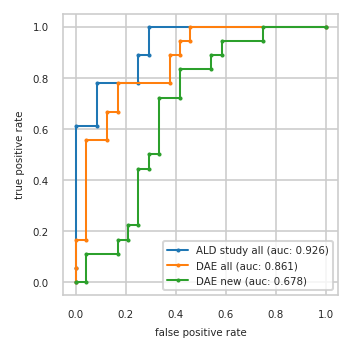

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.611   0.000 0.167   0.042 0.111
3          0.083 0.611   0.042 0.167   0.167 0.111
4          0.083 0.778   0.042 0.556   0.167 0.167
5          0.250 0.778   0.125 0.556   0.208 0.167
6          0.250 0.889   0.125 0.667   0.208 0.222
7          0.292 0.889   0.167 0.667   0.250 0.222
8          0.292 1.000   0.167 0.778   0.250 0.444
9          1.000 1.000   0.375 0.778   0.292 0.444
10           NaN   NaN   0.375 0.889   0.292 0.500
11           NaN   NaN   0.417 0.889   0.333 0.500
12           NaN   NaN   0.417 0.944   0.333 0.722
13           NaN   NaN   0.458 0.944   0.417 0.722
14           NaN   NaN   0.458 1.000   0.417 0.833
15           NaN   NaN   1.000 1.000   0.542 0.833
16           NaN   NaN     NaN   NaN   0.542 0.889
17           NaN   NaN     NaN   NaN   0.583 0.889
18           NaN   NaN     NaN   NaN   0.583 0.944
19           NaN   NaN     NaN   NaN   0.750 0.944
20           NaN   NaN     NaN   NaN   0.750 1.000
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,A6NFX8;Q9UKK9,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,P09486,A6NNI4;G8JLH6;P21926,A0A0C4DGV8;Q13214;Q13214-2
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,Q96GD0
4,P14174,P61981,P31321
5,P10636-2;P10636-6,P25189;P25189-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,Q9Y2T3;Q9Y2T3-3,P04075,A0A075B7B8
7,P61981,P14174,P51688
8,None,Q14894,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


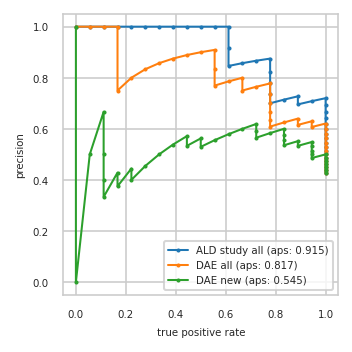

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.630 0.944     0.556 0.833
16         0.692 1.000     0.615 0.889     0.577 0.833
17         0.720 1.000     0.640 0.889     0.600 0.833
18         0.708 0.944     0.625 0.833     0.583 0.778
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.700 0.778     0.700 0.778     0.600 0.667
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.778 0.778     0.778 0.778     0.556 0.556
25         0.824 0.778     0.765 0.722     0.529 0.500
26         0.875 0.778     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.533 0.444
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.917 0.611     0.833 0.556     0.500 0.333
31         1.000 0.611     0.909 0.556     0.455 0.278
32         1.000 0.556     0.900 0.500     0.400 0.222
33         1.000 0.500     0.889 0.444     0.444 0.222
34         1.000 0.444     0.875 0.389     0.375 0.167
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


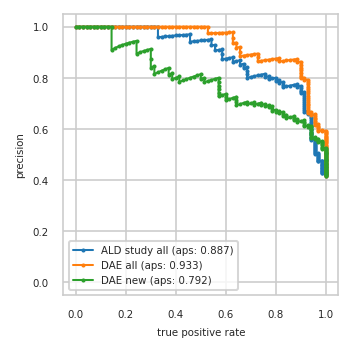

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


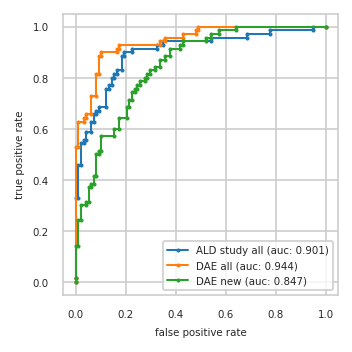

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}